In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sb

## Read file and display some data

In [2]:
names = ['userid', 'itemid', 'rating', 'timestamp']
raw_data = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)

print('Count of ratings', len(raw_data))
print('First ten rows')
print(raw_data[0:10])

# save data in a numpy array where each user ratings have their own rows
userids = sorted(list(raw_data['userid'].unique()))
itemids = sorted(list(raw_data['itemid'].unique()))

# first save in list of lists, use None values if user has not rated item
data = [[None] * len(itemids) for x in range(len(userids))]

# find ratings made by each user
for i in range(len(userids)):
    # dict of ratings for user i+1 (key = itemid, value = rating)
    user_ratings = dict(zip(raw_data.loc[raw_data['userid'] == (i+1)].itemid, raw_data.loc[raw_data['userid'] == (i+1)].rating))
    for j in range(len(itemids)):
        # check if user has rated item with id j+1
        if j+1 in user_ratings:
            data[i][j] = user_ratings[j+1]

data = np.array(data)

Count of ratings 100000
First ten rows
   userid  itemid  rating  timestamp
0     196     242       3  881250949
1     186     302       3  891717742
2      22     377       1  878887116
3     244      51       2  880606923
4     166     346       1  886397596
5     298     474       4  884182806
6     115     265       2  881171488
7     253     465       5  891628467
8     305     451       3  886324817
9       6      86       3  883603013


## User-based collaborativve filtering approach using Pearson correlation function

In [3]:
# a, b = userids, data = whole data set
def pearson_correlation(a, b, data):
    # ratings of users a and b
    data_a = data[a-1] # remember that indexing starts from 0, but userids from 1
    data_b = data[b-1]

    # dicts with itemids and ratings
    dict_a = {i: r for i, r in enumerate(data_a, start=1) if r is not None}
    dict_b = {i: r for i, r in enumerate(data_b, start=1) if r is not None}

    # intersections of common itemids
    P = list(set(dict_a).intersection(set(dict_b)))

    # keep only common itemids
    dict_a = {id: dict_a[id] for id in P}
    dict_b = {id: dict_b[id] for id in P}

    mean_a = np.mean(list(dict_a.values()))
    mean_b = np.mean(list(dict_b.values()))
    n = 0
    d1 = 0
    d2 = 0
    
    # calculate sums
    for item in P:
        n += ((dict_a[item] - mean_a) * (dict_b[item] - mean_b))
        d1 += ((dict_a[item] - mean_a) ** 2)
        d2 += ((dict_b[item] - mean_b) ** 2)
    
    # handle cases where n == 0 and d might be zero as well
    if n == 0:
        return 0

    sim = n / (np.sqrt(d1) * np.sqrt(d2))
    
    # TEST CODE TO CHECK CALCULATIONS, REMOVE BEFORE SUBMISSION?
    # compare to scipys result, with some values the 16th decimal can be different -> round to 10 decimal places
    #scipy_sim, p = stats.pearsonr(list(dict_a.values()), list(dict_b.values()))
    #if np.round(sim, 10) == np.round(scipy_sim, 10):
    #    print(sim, scipy_sim)
    #    print('all ok')
    
    return sim

#### Similarity matrix of all users (makes later calculations faster)

In [11]:
sim_matrix = [[1] * len(userids) for x in range(len(userids))]
for i in range(len(userids)):
    for j in range(i+1, len(userids)):
        sim_matrix[i][j] = sim_matrix[j][i] = pearson_correlation(i+1, j+1, data)

sim_matrix = np.array(sim_matrix)

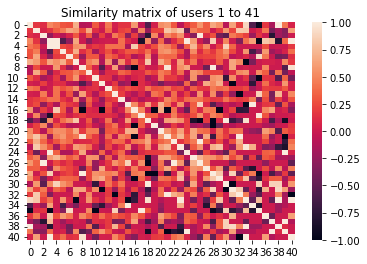

In [12]:
# test with smaller data size (41 users)
test_matrix = [[1] * int(len(userids)/23) for x in range(int(len(userids)/23))]
for i in range(int(len(userids)/23)):
    for j in range(i+1, int(len(userids)/23)):
        test_matrix[i][j] = test_matrix[j][i] = pearson_correlation(i+1, j+1, data)

test_matrix = np.array(test_matrix)

# heatmap of the similarity matrix
sb.heatmap(test_matrix)
plt.title('Similarity matrix of users 1 to 41')
plt.show()

## Prediction function for predicting movie scores

In [13]:
# a = userid, p = itemid, data = whole data set, 
# sim = similarities between given user a and other users, t = similarity threshold
def pearson_predict(a, p, data, sim, t):
    # mean of ratings given by user a
    mean_a = np.mean([r for r in data[a-1] if r is not None])

    # transform similarities to dict (key = userid, value = similarity) and filter out unvanted similarities
    sim = {i: s for i, s in enumerate(sim, start=1) if s >= t}

    n = 0
    d = 0

    for b in sim:
        # chekc if similar user has not rated the item
        if data[b-1][p-1] == None:
            continue

        mean_b = np.mean([r for r in data[b-1] if r is not None])
        n += sim[b] * (data[b-1][p-1] - mean_b)
        d += sim[b]

    if n == 0:
        return mean_a

    return mean_a + n/d

## Show n most similar users for any given user

In [14]:
def n_most_similar_users(n, sim):
    # transform similarities to dict (key = userid, value = similarity)
    sim = {i: s for i, s in enumerate(sim, start=1)}

    # sort similarities based on dict values and return n highest values
    sim = dict(sorted(sim.items(), key=lambda x: x[1], reverse=True))
    return dict(list(sim.items())[:n])

## Ten most similar users to user 345

In [16]:
USER = 15
n = 10
users = n_most_similar_users(n, sim_matrix[USER-1])
df = pd.DataFrame(list(zip(list(users.keys()), list(users.values()))), columns=['userid', 'similarity'])
print(df)

   userid  similarity
0      51    1.000000
1     700    1.000000
2      15    1.000000
3     218    1.000000
4     358    1.000000
5     369    1.000000
6     225    1.000000
7     685    0.948683
8     609    0.911967
9     607    0.904534


## Recommended 20 movies for the same user

In [24]:
# find items the user has not rated
items = [m for m, r in enumerate(data[USER-1], start=1) if r is None]

predictions = {}

for item in items:
    predictions[item] = pearson_predict(USER, item, data, sim_matrix[USER-1], 0.5)

# sort predictions and take 20 highest
most_relevant = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True))
df = pd.DataFrame(list(zip(list(most_relevant.keys()), list(most_relevant.values()))), columns=['itemid', 'rating pred'])[:20]
print(df)


    itemid  rating pred
0      287     5.482143
1      741     4.946795
2      853     4.946795
3      532     4.843992
4      372     4.840753
5     1167     4.840753
6     1400     4.840753
7     1137     4.678529
8     1062     4.532895
9      972     4.525485
10    1639     4.525485
11    1125     4.498188
12    1306     4.498188
13    1503     4.489458
14     835     4.325445
15     371     4.318432
16     553     4.293079
17    1053     4.293079
18    1282     4.293079
19     898     4.290179
